In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

from IPython.display import display
	# make it not fail in terminal execution

# Fix random early on
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Dataset
from torchvision import datasets

flowers_orig = torch.utils.data.ConcatDataset([
	datasets.Flowers102('./data', download=True, split="train"),
	datasets.Flowers102('./data', download=True, split="test"),
	datasets.Flowers102('./data', download=True, split="val")
])

celeba_orig = torch.utils.data.Subset(
	datasets.CelebA('./data', download=True, split="all"),
		# To compare the model on a different dataset it should be the same size (currently 8k vs 200k)
	np.random.choice(len(flowers_orig), len(flowers_orig), replace=False)
)

# Show sizes
def analyze_size(imgs, text):
	sizes = pd.DataFrame([np.array(img).shape for img, _ in imgs])
	cols = ["height", "width", "channels"]
	sizes.columns = cols
	grouped_df = sizes.groupby(cols).size().reset_index(name='count')
	display(grouped_df.head())
	print(text, "min height", sizes["height"].min())
	print(text, "min width", sizes["width"].min())

analyze_size(flowers_orig, "Flowers102")
analyze_size(celeba_orig, "CelebA")

Files already downloaded and verified


,height,width,channels,count
0,500,500,3,70
1,500,501,3,2
2,500,502,3,10
3,500,503,3,10
4,500,504,3,11


Flowers102 min height 500
Flowers102 min width 500


,height,width,channels,count
0,218,178,3,8189


CelebA min height 218
CelebA min width 178


In [3]:
# Merge train, test, val
def PrepareData(dataset, transform, text):
	# Apply transform after loaded
	dataset = [(transform(img), target) for img, target in dataset]

	# Reanalyze size
	analyze_size(dataset, text)

	# Data contains classification
	images = np.array( [np.array(img) for img, target in dataset] )
	print(images.shape)
	return images

from torchvision.transforms.v2 import CenterCrop

# Data cleansing

# Crop to same size
# Resize for consumer gpu
# To tensor for neural network
# Make mean 0 to match noise's mean
flowerTensors = PrepareData(flowers_orig, transforms.Compose([
	transforms.CenterCrop(500),
	transforms.Resize(64),
	transforms.ToTensor(),
	transforms.Lambda(lambda img: (img - 0.5) * 2)
]), "Flowers102")
celebaTensors = PrepareData(celeba_orig, transforms.Compose([
	transforms.CenterCrop(178),
	transforms.Resize(64),
	transforms.ToTensor(),
	transforms.Lambda(lambda img: (img - 0.5) * 2)
]), "CelebA")

# Reverse transform
tensorToImage = transforms.Compose([
	transforms.Lambda(lambda img: img / 2 + 0.5),
	transforms.Lambda(lambda img: img.permute(1, 2, 0).numpy() * 255),
	transforms.Lambda(lambda img: img.astype(np.uint8))
])

,height,width,channels,count
0,3,64,64,8189


Flowers102 min height 3
Flowers102 min width 64
(8189, 3, 64, 64)


,height,width,channels,count
0,3,64,64,8189


CelebA min height 3
CelebA min width 64
(8189, 3, 64, 64)


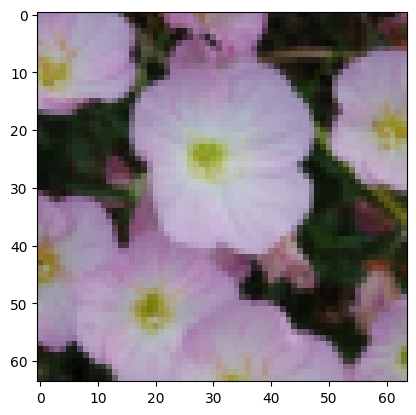

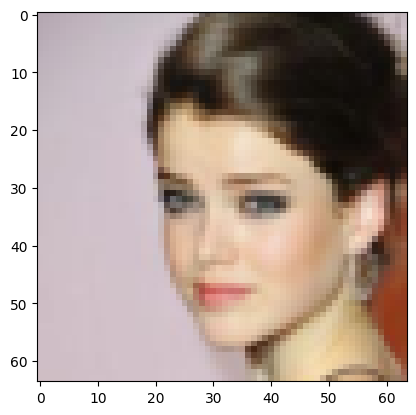

In [9]:
plt.imshow(tensorToImage(torch.from_numpy(flowerTensors[0])))
plt.figure()
plt.imshow(tensorToImage(torch.from_numpy(celebaTensors[0])))

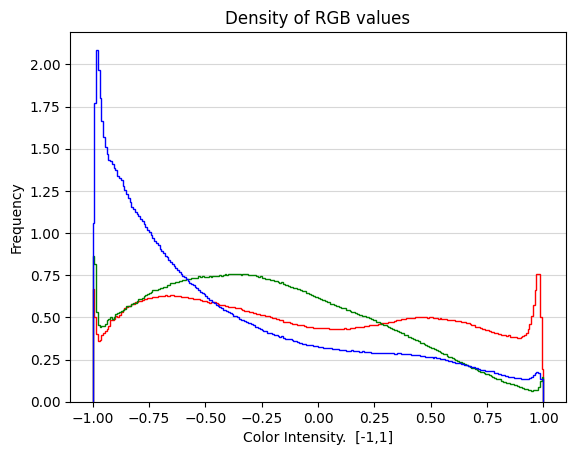

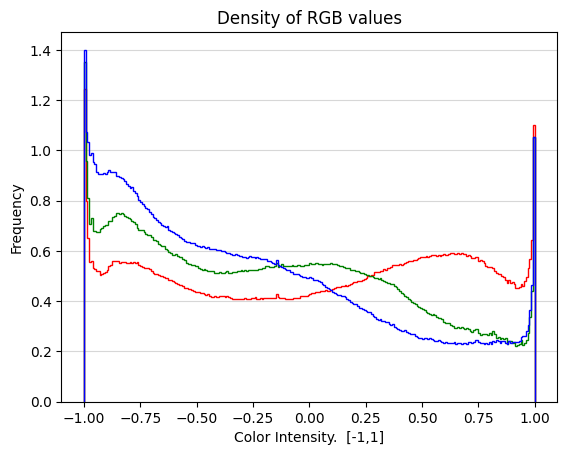

In [10]:
# Data analysis

# Distribution of (normalized) pixels
def img_histogram(data):
	for i, color in enumerate(["red", "green", "blue"]):
		plt.hist(data[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
	plt.title('Density of RGB values')
	plt.xlabel('Color Intensity.  [-1,1]')
	plt.ylabel('Frequency')
	plt.grid(axis='y', alpha=0.5)
	plt.show()
img_histogram(flowerTensors)
plt.figure()
img_histogram(celebaTensors)

In [11]:
from sklearn.model_selection import train_test_split

def split(dataset):
	train, test = train_test_split(dataset, test_size=0.2, random_state=42)
	test, val = train_test_split(test, test_size=0.5, random_state=42)
	print(train.shape)
	print(test.shape)
	print(val.shape)
	return train, test, val

flowerTrain, flowerTest, flowerVal = split(flowerTensors)
celebaTrain, celebaTest, celebaVal = split(celebaTensors)

(6551, 3, 64, 64)
(819, 3, 64, 64)
(819, 3, 64, 64)
(6551, 3, 64, 64)
(819, 3, 64, 64)
(819, 3, 64, 64)


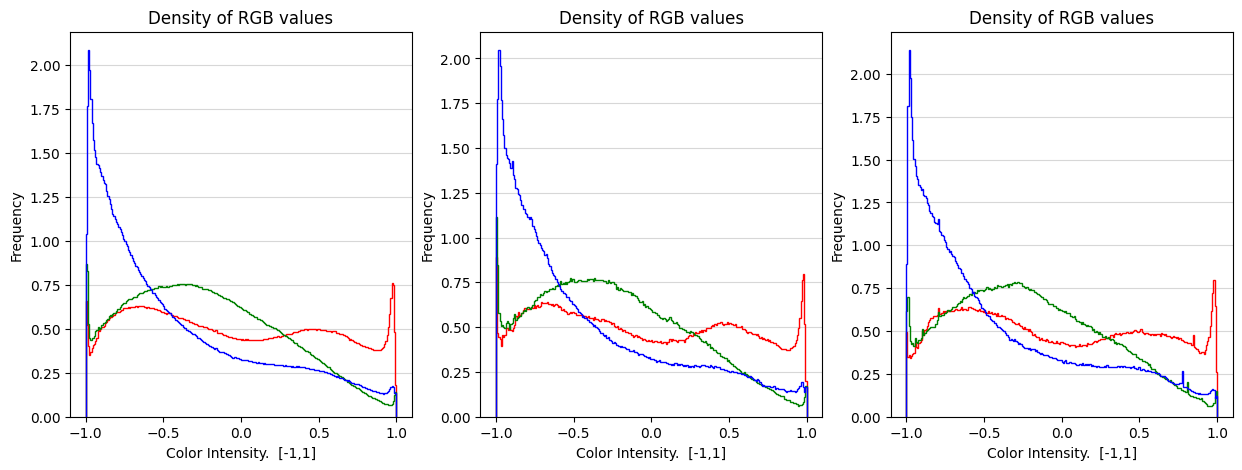

<Figure size 640x480 with 0 Axes>

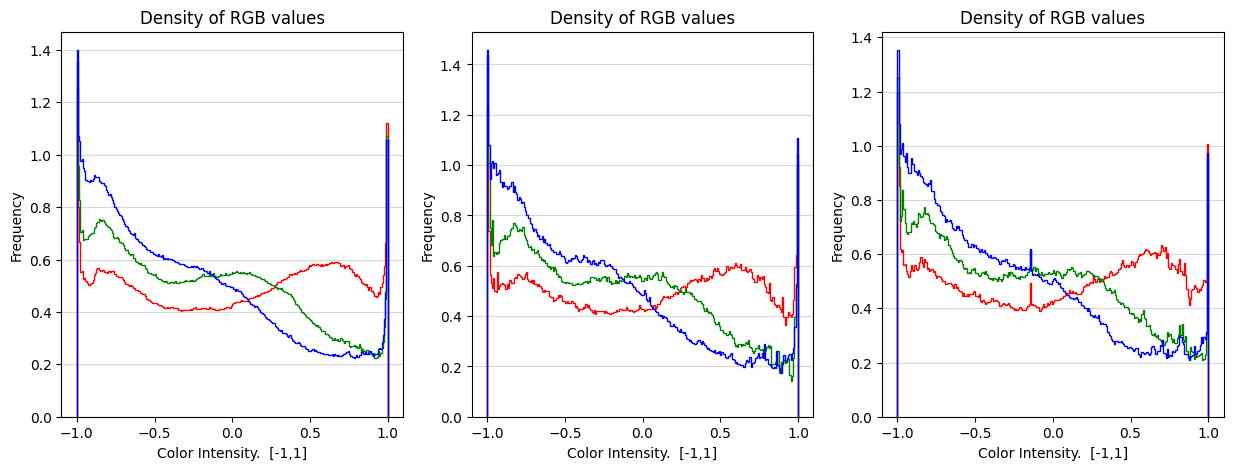

In [12]:
# Check if distribution is similar between train, test, val
def split_histogram(train, test, val):
	fig, axs = plt.subplots(1, 3, figsize=(15, 5))
	for idx, dataset in enumerate([train, test, val]):
		for i, color in enumerate(["red", "green", "blue"]):
			axs[idx].hist(dataset[:, i, :, :].flatten(), bins=256, range=(-1, 1), color=color, histtype=u'step', density=True)
		axs[idx].set_title('Density of RGB values') # can't use existing function because it's not .title 🙃
		axs[idx].set_xlabel('Color Intensity.  [-1,1]') # ...
		axs[idx].set_ylabel('Frequency') # ...
		axs[idx].grid(axis='y', alpha=0.5)
	plt.show()

split_histogram(flowerTrain, flowerTest, flowerVal)
plt.figure()
split_histogram(celebaTrain, celebaTest, celebaVal)

In [13]:
batch_size = 64
def create_loader(train, test, val):
	# Already shuffled by split train test
	trainLoader = DataLoader(train, batch_size=batch_size, shuffle=False)
	testLoader = DataLoader(test, batch_size=batch_size, shuffle=False)
	valLoader = DataLoader(val, batch_size=batch_size, shuffle=False)
	return trainLoader, testLoader, valLoader
flowerTrainLoader, flowerTestLoader, flowerValLoader = create_loader(flowerTrain, flowerTest, flowerVal)
celebaTrainLoader, celebaTestLoader, celebaValLoader = create_loader(celebaTrain, celebaTest, celebaVal)

In [ ]:
# gyakorlat: docker hogyan
# cleansing (kép szórás eloszlás, kicsik kidobása)

# keresztvalidáció
# min max scaler csak tanítótól függjön!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# todo: fix random
# baseline legyen mintavételezés az eloszlásból
# vae baseline, test on own gpu

# T db gauss zaj hozzáadás: várh érték függ az előző képtől?: https://huggingface.co/blog/annotated-diffusion
# variancia változik minden üzemben (~learning rate schedule)
# lehetne hiperparaméter a beta scheduler is (lineáris, exponenciális)

# Releváns laborok: Gépi labor 4. VAE
# Jó levezetés: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/